# Interactive clustering and annotation of VAE_SBF2/CondVAE_siRNA-CC experiment

This notebook creates a sub-subsampled mpp data `aggregated/sub-0.005_sub-0.33` from the previously created mpp data `aggregated/sub-0.005`, as the latter mpp data was too big for interactive clustering, and 1/3 of the data is sufficient to get good clusters.

Then, the clusterings `clustering_res0.9_seed1.npy`, `clustering_res0.9_seed2.npy`, `clustering_res0.9_seed3.npy` are created.

In [1]:
from miann.constants import EXPERIMENT_DIR
from miann.data import MPPData
from miann.tl import Experiment
from miann.tl import Cluster
from miann.tl._cluster import add_clustering_to_adata
from miann.pl import annotate_img
import os
import numpy as np
import scanpy as sc

In [2]:
exp_name = 'VAE_SBF2/CondVAE_siRNA-CC'
cluster_data_dir = os.path.join(exp_name, 'aggregated/sub-0.005_sub-0.33')

## Subsample subsampled data

In [13]:
mpp_data = MPPData.from_data_dir(f'{exp_name}/aggregated/sub-0.005', 
                                 optional_keys=['latent', 'labels', 'conditions', 'umap'], base_dir=EXPERIMENT_DIR)

# subsample by 0.33
np.random.seed(0)
mask = np.random.choice(len(mpp_data.obj_ids), size=int(len(mpp_data.obj_ids)*0.33), replace=False)
mpp_data.apply_mask(mask)
mpp_data.write(os.path.join(EXPERIMENT_DIR, cluster_data_dir))

In [42]:
import json
params = json.load(open(os.path.join(EXPERIMENT_DIR, exp_name, 'aggregated/sub-0.005/cluster_params.json')))
params['cluster_data_dir'] = cluster_data_dir
json.dump(params, open(os.path.join(EXPERIMENT_DIR, cluster_data_dir, 'cluster_params.json'), 'w'), indent=4)


## Cluster data

In [ ]:
# load cl
cl = Cluster.from_cluster_data_dir(cluster_data_dir)
# get adata object
adata = cl.cluster_mpp.get_adata(X='mpp', obsm={'X_latent': 'latent', 'X_umap': 'umap'})

In [ ]:
sc.pp.neighbors(adata, use_rep='X_latent')
sc.tl.leiden(adata, resolution=0.9, key_added='clustering_res0.9_sub-0.33_seed1', random_state=1)
sc.tl.leiden(adata, resolution=0.9, key_added='clustering_res0.9_sub-0.33_seed2', random_state=2)
sc.tl.leiden(adata, resolution=0.9, key_added='clustering_res0.9_sub-0.33_seed3', random_state=3)

# write clustering to disk
np.save(os.path.join(EXPERIMENT_DIR, cluster_data_dir, 'clustering_res0.9_sub-0.33_seed1'), adata.obs['clustering_res0.9_sub-0.33_seed1'])
np.save(os.path.join(EXPERIMENT_DIR, cluster_data_dir, 'clustering_res0.9_sub-0.33_seed2'), adata.obs['clustering_res0.9_sub-0.33_seed2'])
np.save(os.path.join(EXPERIMENT_DIR, cluster_data_dir, 'clustering_res0.9_sub-0.33_seed3'), adata.obs['clustering_res0.9_sub-0.33_seed3'])

## Explore clustered data

In [6]:
# comment in for logging messages
#import logging
#logging.basicConfig(level=logging.INFO)

In [3]:
# quick plotting functions for looking at results
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def plot_loadings(adata,var='clustering'):
    pixel_values_annotated = pd.concat([
        pd.DataFrame(adata.X,columns=adata.var_names).reset_index(drop=True),
        adata.obs[[var]].reset_index(drop=True)],
        axis=1)
    #col_standard = sns.clustermap(pixel_values_annotated.groupby(var).aggregate('mean'), z_score=0, cmap="vlag", figsize=[10,4],vmin=-3, vmax=3)
    row_standard = sns.clustermap(pixel_values_annotated.groupby(var).aggregate('mean'), z_score=1, cmap="vlag", figsize=[14,9],vmin=-3, vmax=3, method='ward')
    
def plot_count_per_condition(var='clustering'):
    count_per_condition = adata.obs[['mapobject_id','perturbation_duration', var]].groupby(['perturbation_duration', var]).agg(['count'])
    count_per_condition.reset_index(level=0,inplace=True)
    count_per_condition = count_per_condition.pivot(columns='perturbation_duration')
    count_per_condition = count_per_condition / count_per_condition.sum()
    count_per_condition.index = count_per_condition.index.astype(int)
    count_per_condition = count_per_condition.sort_index()

    plt.rcParams['figure.figsize'] = [10, 14]
    fig,axes = plt.subplots(2,1)

    axes[0] = count_per_condition.plot.bar(ax=axes[0])
    axes[1] = sns.heatmap(count_per_condition.transpose())

# projection function to example subset
def project_clustering(cl, mpp_data: MPPData, obj_ids=[], num_objs=5, cluster_name='clustering'):
    """ 
    project clustering to example obj_ids. 
    Either a list of obj_ids can be specified, or a number of randomly drawn objects.

    Args:
        cl: reference clustering
        mpp_data: data containing the obj_ids to project
    """
    # set cluster_name to project
    cl.set_cluster_name(cluster_name)
    if len(obj_ids)==0:
        rng = np.random.default_rng(seed=42)
        obj_ids = rng.choice(mpp_data.unique_obj_ids, num_objs, replace=False)
    sub_mpp_data = mpp_data.subset(obj_ids=obj_ids, copy=True)
    sub_mpp_data = cl.project_clustering(sub_mpp_data)
    return sub_mpp_data

def load_full_data_dict(exp_name, keys=['x', 'y', 'obj_ids', 'latent']):
    """
    load mpp_datas used in experiment exp_name in a dict.
    NOTE: this might take a few minutes, as all data needs to be loaded. 
    
    Args:
        keys: controls which np data matrices are being loaded. Excluding mpp here speeds up loading
    """
    exp = Experiment.from_dir(exp_name)
    mpp_datas = {}
    for data_dir in exp.data_params['data_dirs']:
        print(data_dir)
        try:
            mpp_datas[data_dir] = MPPData.from_data_dir(data_dir, base_dir=os.path.join(exp.full_path, 'aggregated/full_data'), 
                                                        keys=keys, optional_keys=[])
        except FileNotFoundError as e:
            continue
    return mpp_datas

def get_clustered_cells(mpp_datas, cl, cluster_name, num_objs=5):
    """
    get x example cells for each well. Returns a dict, containing clustering cluster_name and colored cells in cluster_name_colored
    """
    cl.set_cluster_name(cluster_name)
    res = {cluster_name:{}, cluster_name+'_colored':{}}
    for data_dir, mpp_data in mpp_datas.items():
        print(data_dir)
        sub_mpp_data = project_clustering(cl, mpp_data, num_objs=num_objs, cluster_name=cluster_name)
        # if only need colored cells, can pass annotation_kwargs to get_object_imgs
        res[cluster_name][data_dir] = sub_mpp_data.get_object_imgs(data=cluster_name)  #annotation_kwargs={'color': True, 'annotation': cl.cluster_annotation})
        res[cluster_name+'_colored'][data_dir] = [annotate_img(img, annotation=cl.cluster_annotation, from_col=cluster_name, color=True) for img in res[cluster_name][data_dir]]
    return res

In [4]:
# load cl
cl = Cluster.from_cluster_data_dir(cluster_data_dir)
# get adata object
adata = cl.cluster_mpp.get_adata(X='mpp', obsm={'X_latent': 'latent', 'X_umap': 'umap'})

/home/icb/hannah.spitzer/miniconda3/envs/pelkmans-3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
# add clustering and colormap (from cluster_name_annotation.csv) to adata
cl.set_cluster_name('clustering_res0.9_sub-0.33_seed1') 
add_clustering_to_adata(os.path.join(EXPERIMENT_DIR, cluster_data_dir), 'clustering_res0.9_sub-0.33_seed1', adata, cl.cluster_annotation)

cl.set_cluster_name('clustering_res0.9_sub-0.33_seed2') 
add_clustering_to_adata(os.path.join(EXPERIMENT_DIR, cluster_data_dir), 'clustering_res0.9_sub-0.33_seed2', adata, cl.cluster_annotation)

cl.set_cluster_name('clustering_res0.9_sub-0.33_seed3') 
add_clustering_to_adata(os.path.join(EXPERIMENT_DIR, cluster_data_dir), 'clustering_res0.9_sub-0.33_seed3', adata, cl.cluster_annotation)


/home/icb/hannah.spitzer/miniconda3/envs/pelkmans-3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'plate_name' as categorical
/home/icb/hannah.spitzer/miniconda3/envs/pelkmans-3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'well_name' as categorical
/home/icb/hannah.spitzer/miniconda3/envs/pelkmans-3.9/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categ

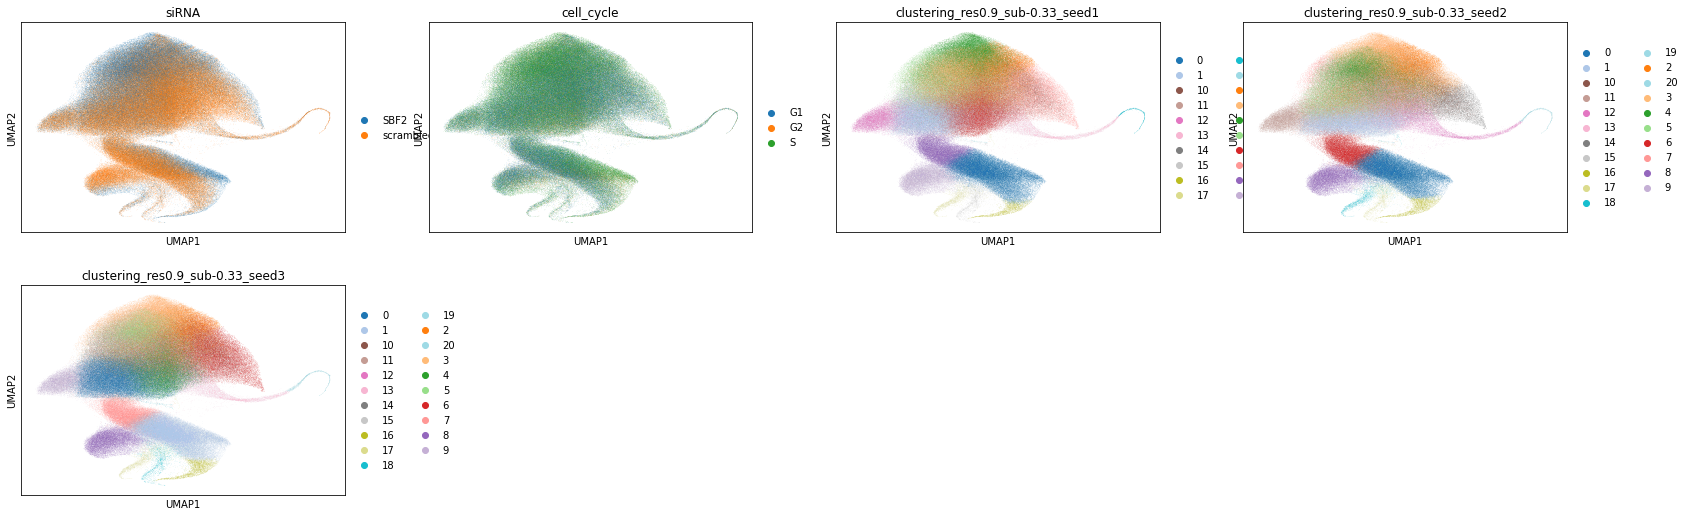

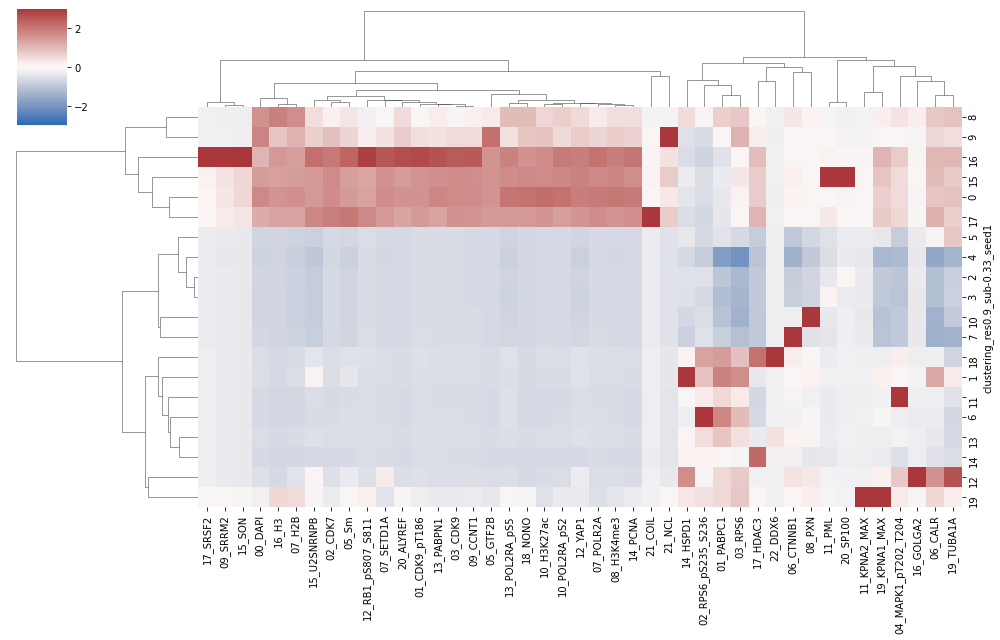

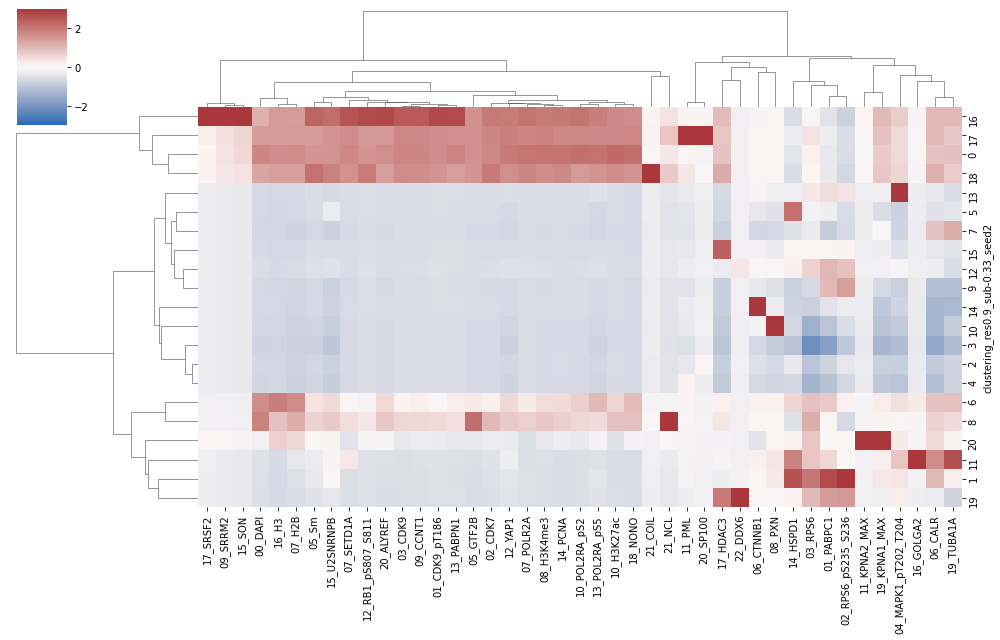

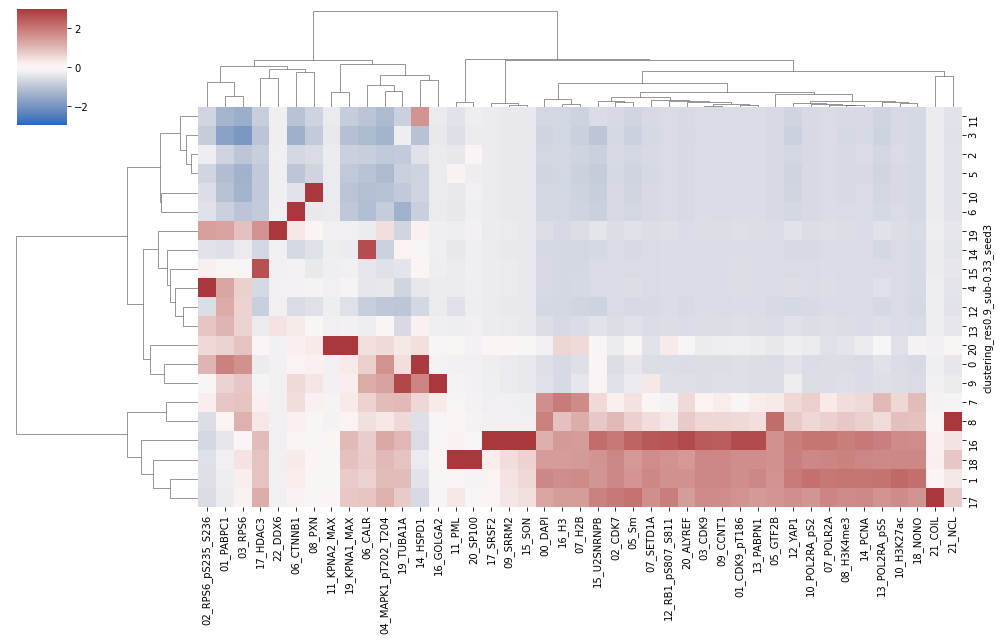

In [6]:
plt.rcParams['figure.figsize'] = [6, 4]
sc.pl.umap(adata, color=['siRNA', 'cell_cycle', 'clustering_res0.9_sub-0.33_seed1', 'clustering_res0.9_sub-0.33_seed2', 
                         'clustering_res0.9_sub-0.33_seed3'], vmax='p99')

plot_loadings(adata, 'clustering_res0.9_sub-0.33_seed1')
plot_loadings(adata, 'clustering_res0.9_sub-0.33_seed2')
plot_loadings(adata, 'clustering_res0.9_sub-0.33_seed3')

In [7]:
# NOTE: this may take a couple of minutes
# load data
mpp_datas = load_full_data_dict(exp_name)
# project clustering to some example cells
example_cells = {}
example_cells.update(get_clustered_cells(mpp_datas, cl, 'clustering_res0.9_sub-0.33_seed1', num_objs=5))
example_cells.update(get_clustered_cells(mpp_datas, cl, 'clustering_res0.9_sub-0.33_seed2', num_objs=5))
example_cells.update(get_clustered_cells(mpp_datas, cl, 'clustering_res0.9_sub-0.33_seed3', num_objs=5))

HeLa_SBF2/K18
HeLa_SBF2/L19
HeLa_SBF2/M18
HeLa_scrambled/K19
HeLa_scrambled/L18
HeLa_scrambled/M19
HeLa_SBF2/K18
HeLa_SBF2/L19
HeLa_SBF2/M18
HeLa_scrambled/K19
HeLa_scrambled/L18
HeLa_scrambled/M19
HeLa_SBF2/K18
HeLa_SBF2/L19
HeLa_SBF2/M18
HeLa_scrambled/K19
HeLa_scrambled/L18
HeLa_scrambled/M19
HeLa_SBF2/K18
HeLa_SBF2/L19
HeLa_SBF2/M18
HeLa_scrambled/K19
HeLa_scrambled/L18
HeLa_scrambled/M19


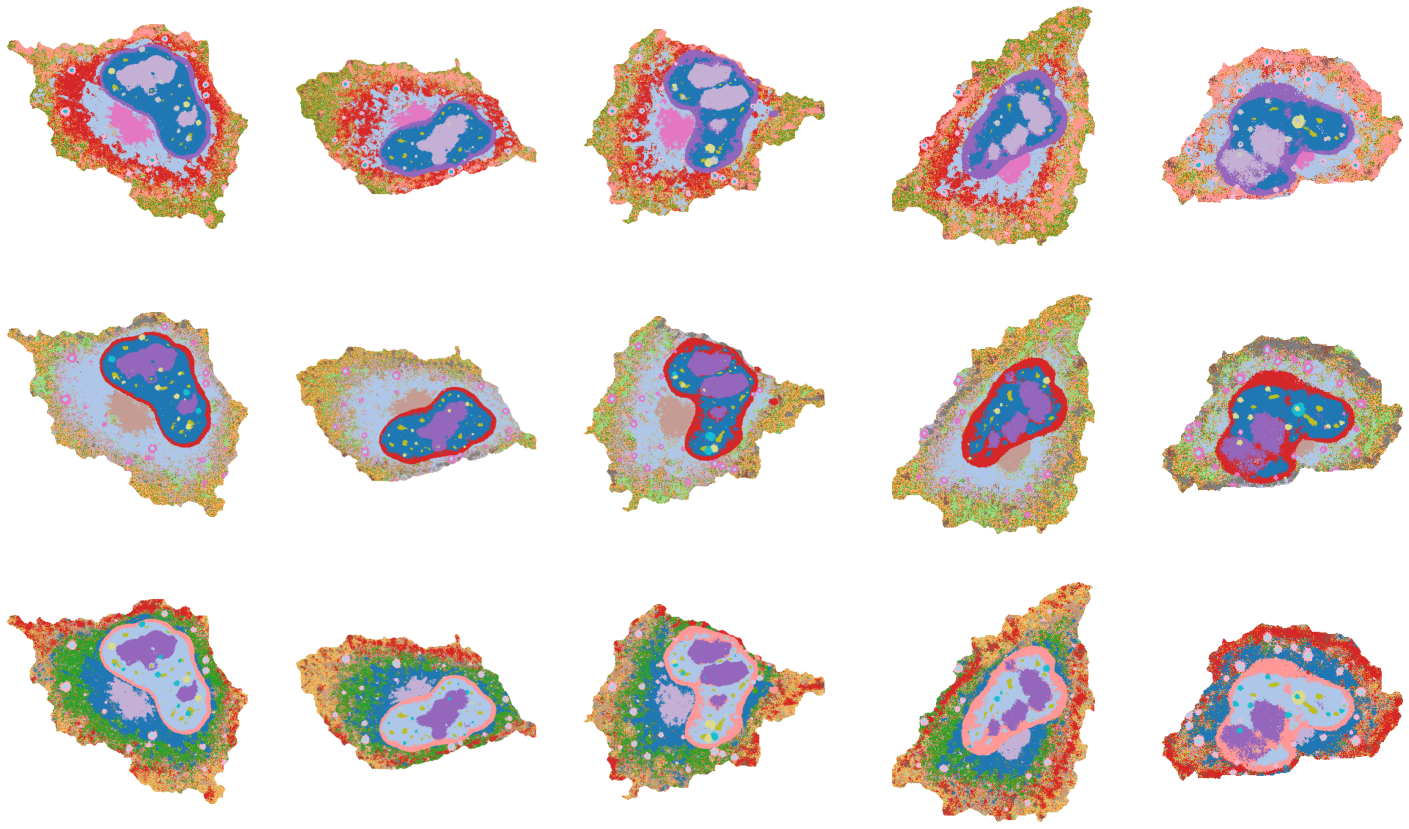

In [8]:
# plot example cells
data_dir = 'HeLa_scrambled/K19'
fig, axes = plt.subplots(3,5, figsize=(25,15))
for i in range(5):
    axes[0,i].imshow(example_cells['clustering_res0.9_sub-0.33_seed1_colored'][data_dir][i])
    axes[1,i].imshow(example_cells['clustering_res0.9_sub-0.33_seed2_colored'][data_dir][i])
    axes[2,i].imshow(example_cells['clustering_res0.9_sub-0.33_seed3_colored'][data_dir][i])
for ax in axes.flat:
    ax.axis('off')

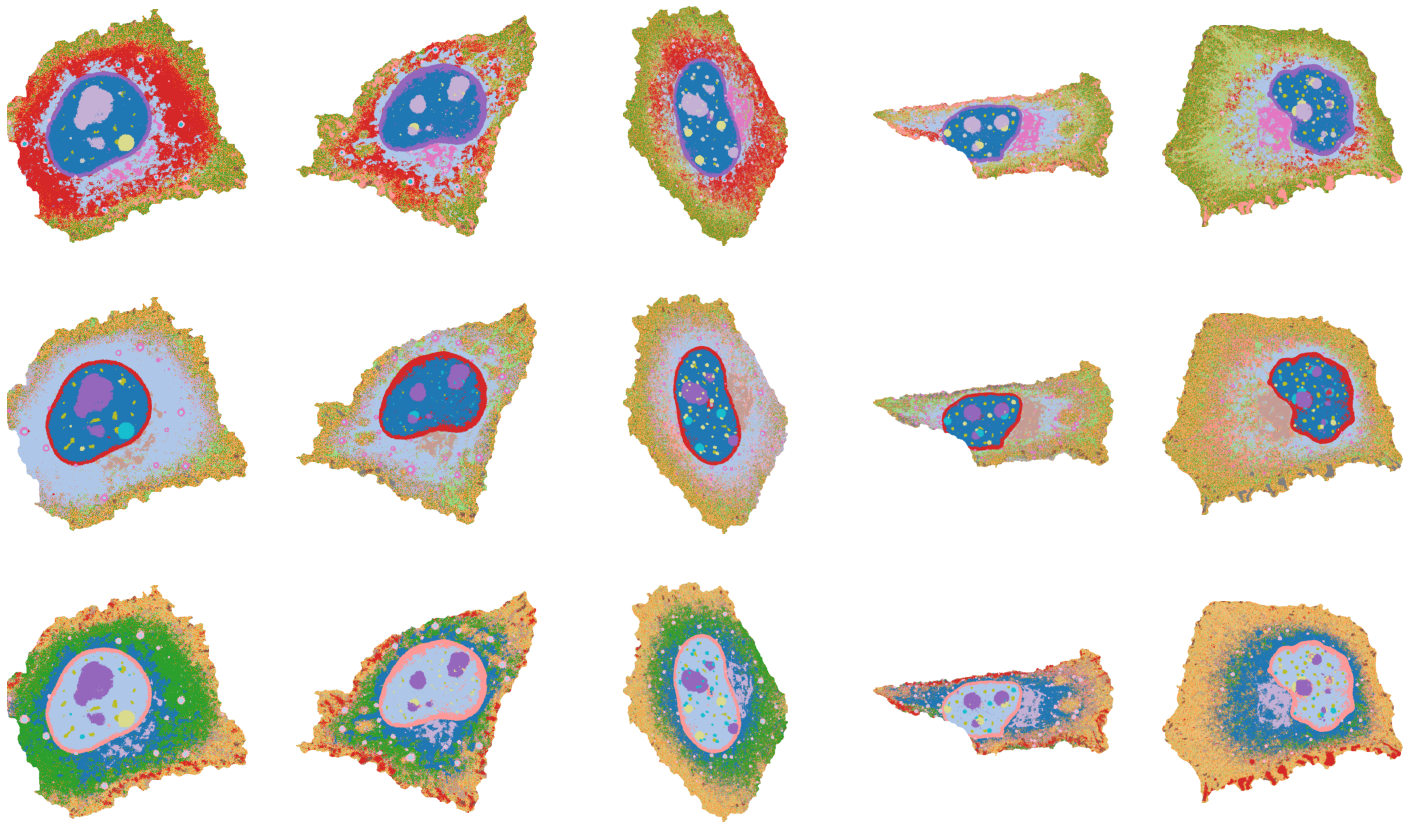

In [9]:
data_dir = 'HeLa_SBF2/M18'
fig, axes = plt.subplots(3,5, figsize=(25,15))
for i in range(5):
    axes[0,i].imshow(example_cells['clustering_res0.9_sub-0.33_seed1_colored'][data_dir][i])
    axes[1,i].imshow(example_cells['clustering_res0.9_sub-0.33_seed2_colored'][data_dir][i])
    axes[2,i].imshow(example_cells['clustering_res0.9_sub-0.33_seed3_colored'][data_dir][i])
for ax in axes.flat:
    ax.axis('off')

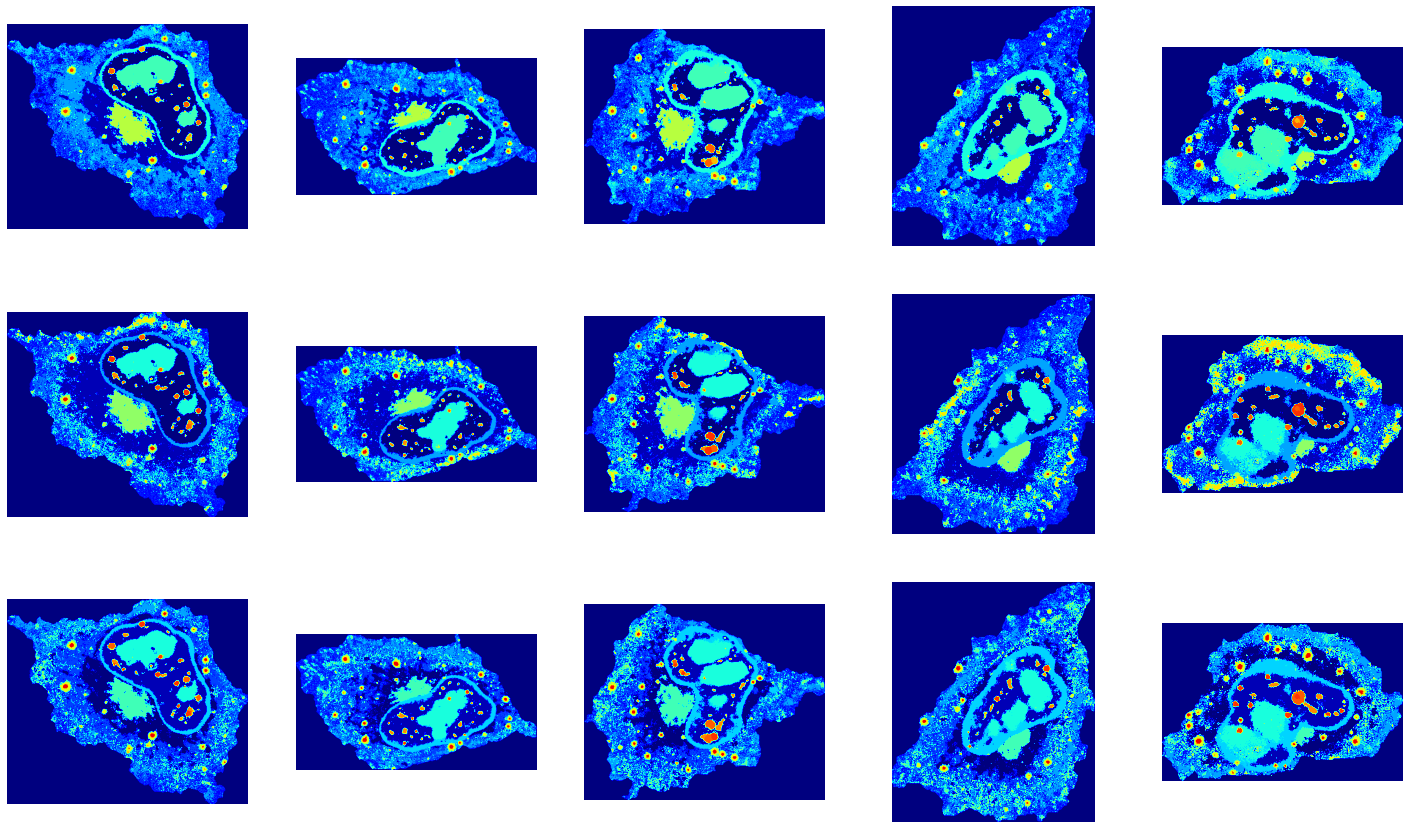

In [10]:
def to_int(arr):
    arr = arr.copy().astype(object)
    arr[arr=='']=0
    arr = arr.astype(int)
    return arr
    #arr.nan_to_num(0)
    
data_dir = 'HeLa_scrambled/K19'
fig, axes = plt.subplots(3,5, figsize=(25,15))
for i in range(5):
    axes[0,i].imshow(to_int(example_cells['clustering_res0.9_sub-0.33_seed1'][data_dir][i]), vmax=21, cmap='jet')
    axes[1,i].imshow(to_int(example_cells['clustering_res0.9_sub-0.33_seed2'][data_dir][i]), vmax=21, cmap='jet')
    axes[2,i].imshow(to_int(example_cells['clustering_res0.9_sub-0.33_seed3'][data_dir][i]), vmax=21, cmap='jet')
for ax in axes.flat:
    ax.axis('off')

## Save annotation

In [24]:
annotation = {'0': 'Nucleoplasm',
              '1': 'Mitochondria ER',
              '2': 'Cytoplasm 1',
              '3': 'Cytoplasm 1',
              '4': 'Cytoplasm 1',
              '5': 'Peripheral microtubules',
              '6': 'Cytoplasm 2',
              '7': 'Cell periphery',
              '8': 'Nuclear periphery',
              '9': 'Nucleolus',
              '10': 'Focal adhesions',
              '11': 'Cytoplasm 3',
              '12': 'Golgi',
              '13': 'P-bodies (periphery)',
              '14': 'Unknown',
              '15': 'PML bodies',
              '16': 'Nuclear speckles',
              '17': 'Cajal bodies',
              '18': 'P-bodies (core)',
              '19': 'Importin-alpha'
             }

cl.set_cluster_name('clustering_res0.9_sub-0.33_seed1')
cl.add_cluster_annotation(annotation, 'annotation')

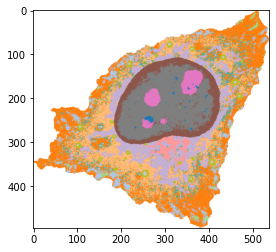

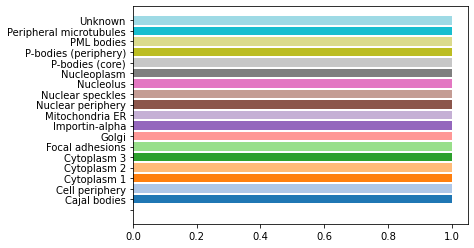

In [15]:
# check out cell colored by new annotation
plt.imshow(annotate_img(example_cells['clustering_res0.9_sub-0.33_seed1']['HeLa_SBF2/M18'][1], 
                        annotation=cl.cluster_annotation, from_col=cl.config['cluster_name'], to_col='annotation', color=True))
plt.show()

# makeshift legend
df = cl.cluster_annotation.groupby('annotation')['annotation_colors'].first()
plt.barh(y=range(len(df)), width=1, color=df)
_ = plt.yticks(range(len(df)), df.index, rotation=0)